In [1]:
import requests
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False


url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [2]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [3]:
# 기술통계값
waterDF.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
수온,404.0,18.056188,8.431139,2.800,10.67500,19.0000,25.22500,32.000
수소이온농도(ph),404.0,7.912376,0.536458,6.500,7.60000,7.9000,8.30000,9.200
전기전도도(EC),404.0,297.460396,107.355447,118.000,206.50000,279.5000,388.00000,516.000
용존산소(DO),404.0,10.372030,2.407574,6.600,8.40000,9.6000,11.92500,16.000
BOD,404.0,1.876485,0.723801,0.400,1.30000,1.7500,2.30000,4.400
COD,404.0,5.998515,1.082983,4.200,5.20000,5.9000,6.60000,11.600
부유물질,404.0,7.247277,7.381532,0.400,3.60000,6.0000,8.80000,100.800
총질소(T-N),404.0,2.449906,0.618431,0.804,2.04225,2.4205,2.91025,3.800
총인(T-P),404.0,0.042918,0.026786,0.015,0.02700,0.0335,0.04900,0.281
총유기탄소(TOC),404.0,3.973762,0.805721,2.100,3.40000,3.9000,4.50000,7.000


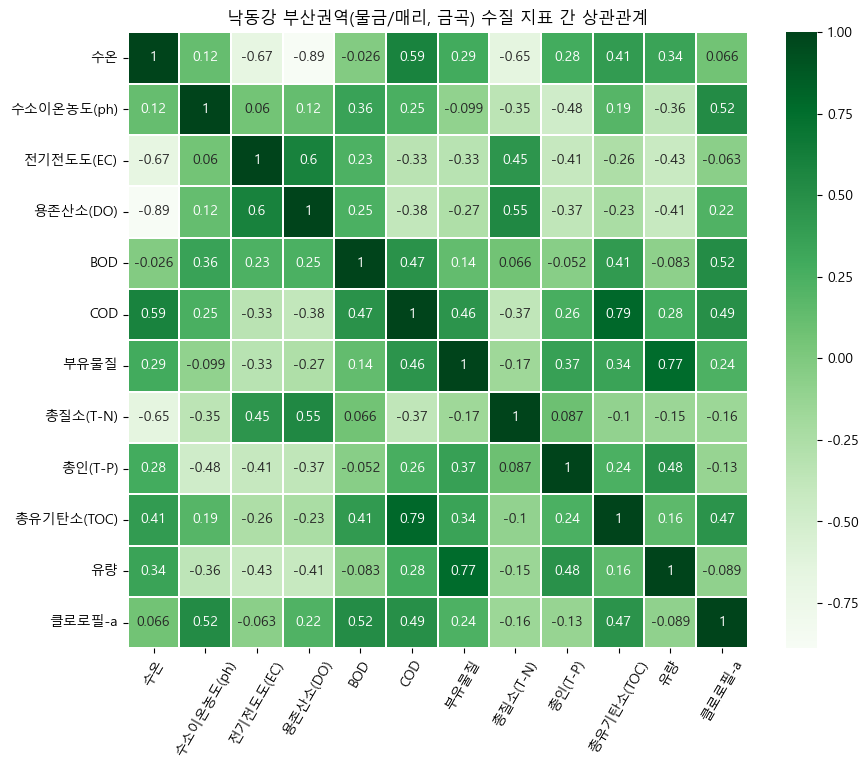

In [4]:
wd = waterDF.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='Greens')
plt.xticks(rotation=60)
plt.title("낙동강 부산권역(물금/매리, 금곡) 수질 지표 간 상관관계")

plt.show()

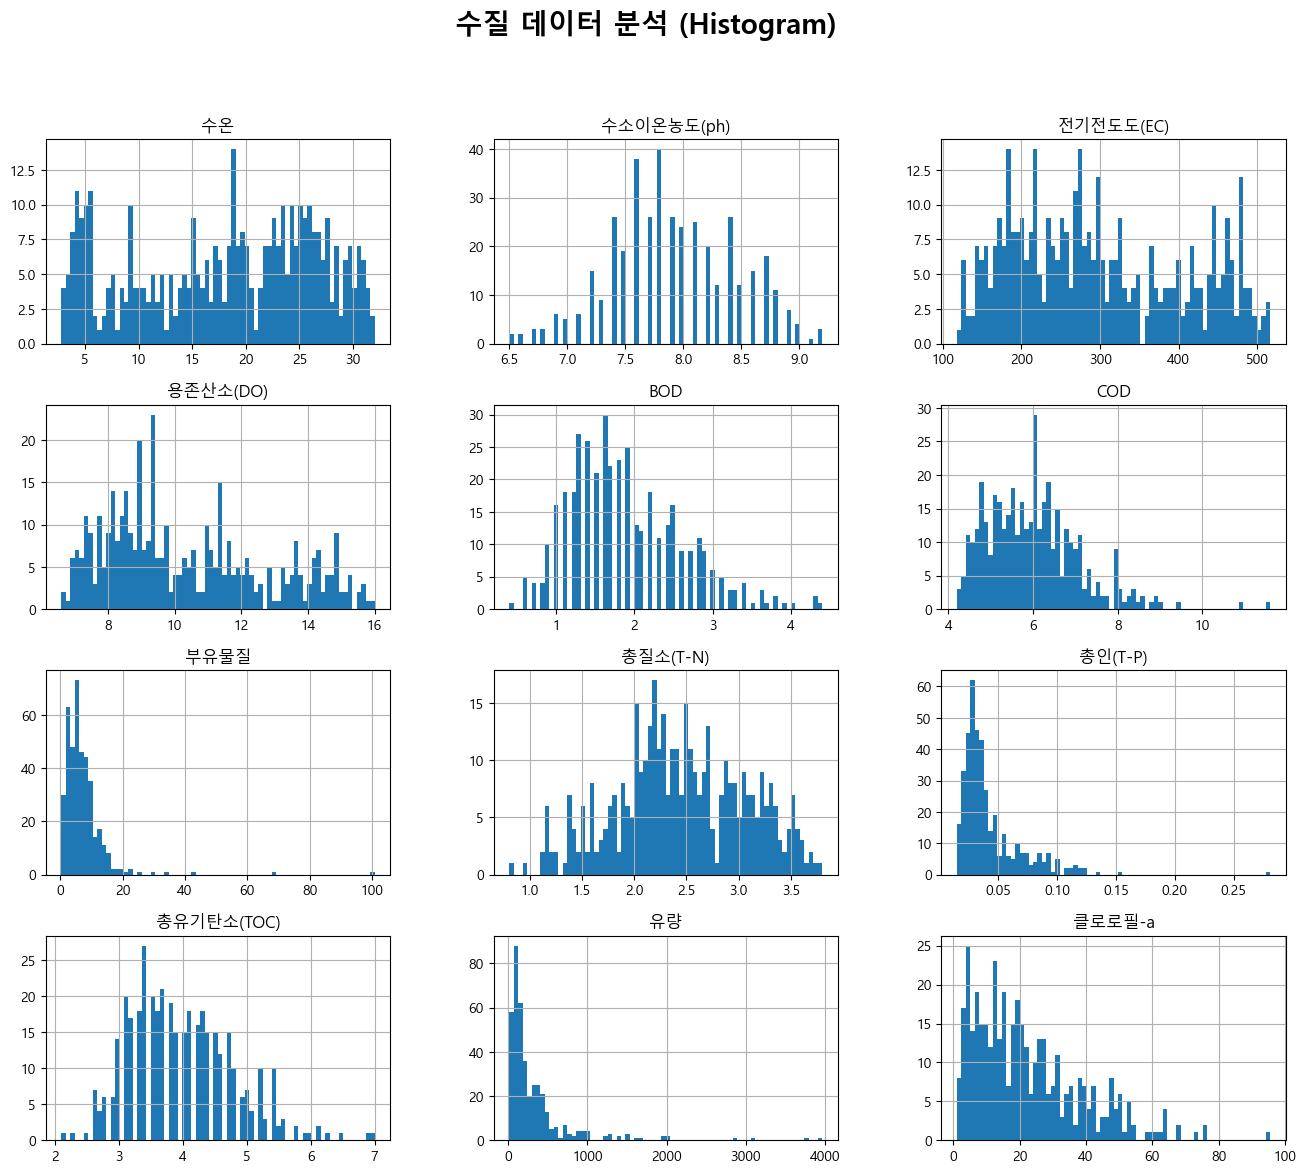

In [5]:
# 전체 데이터에 대한 개괄적인 히스토그램으로 분포 형태, 이상치, 결측치, 시계열/계절성, 데이터 정제 필요성 등 확인
cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량', '클로로필-a']

waterDF[cols].hist(bins=70, figsize=(16, 13))
plt.suptitle('수질 데이터 분석 (Histogram)', fontsize=20, fontweight='bold')

plt.show()

In [6]:
# 부산권역 간 특성이 달라 데이터의 분포 왜곡과 비교분석 오류 방지를 위해 년, 월 컬럼 추가 -> 물금, 금곡으로 분리
waterDF['년'] = waterDF['일자'].dt.year
waterDF['월'] = waterDF['일자'].dt.month

mulgeumDf = waterDF[waterDF['총량지점명'] == '물금'].copy()
geumgogDf = waterDF[waterDF['총량지점명'] == '금곡'].copy()
waterDF['계절구분'] = np.where(waterDF['월'].isin([6,7,8,9]), '여름', '비여름')
waterDF['log_chl'] = np.log1p(waterDF['클로로필-a'])

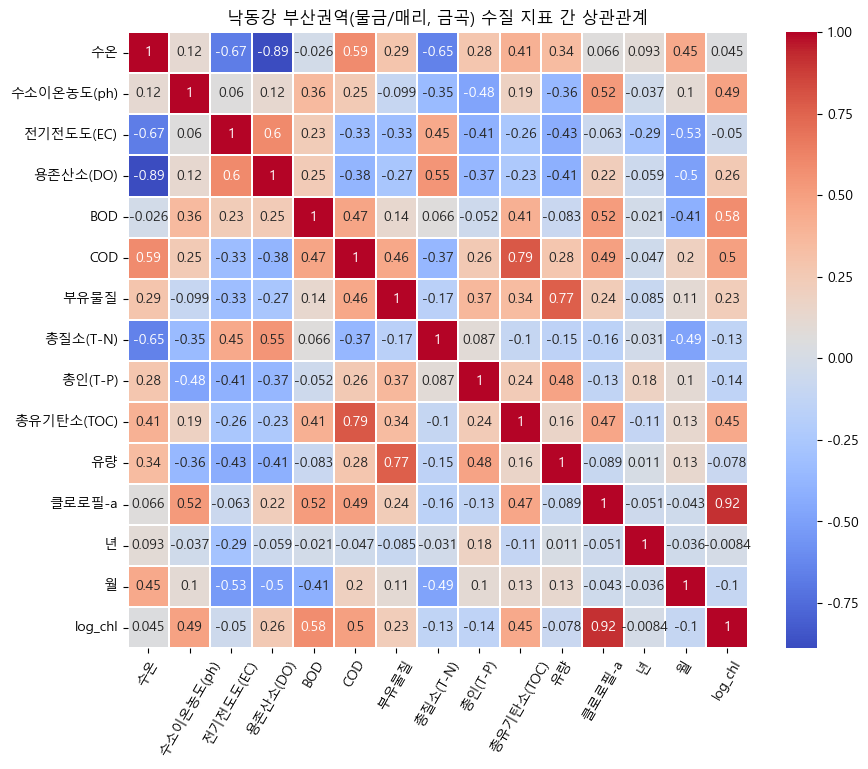

In [7]:
wd = waterDF.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sb.heatmap(wd, annot=True, linewidths=0.3, cmap='coolwarm')
plt.xticks(rotation=60)
plt.title("낙동강 부산권역(물금/매리, 금곡) 수질 지표 간 상관관계")

plt.show()

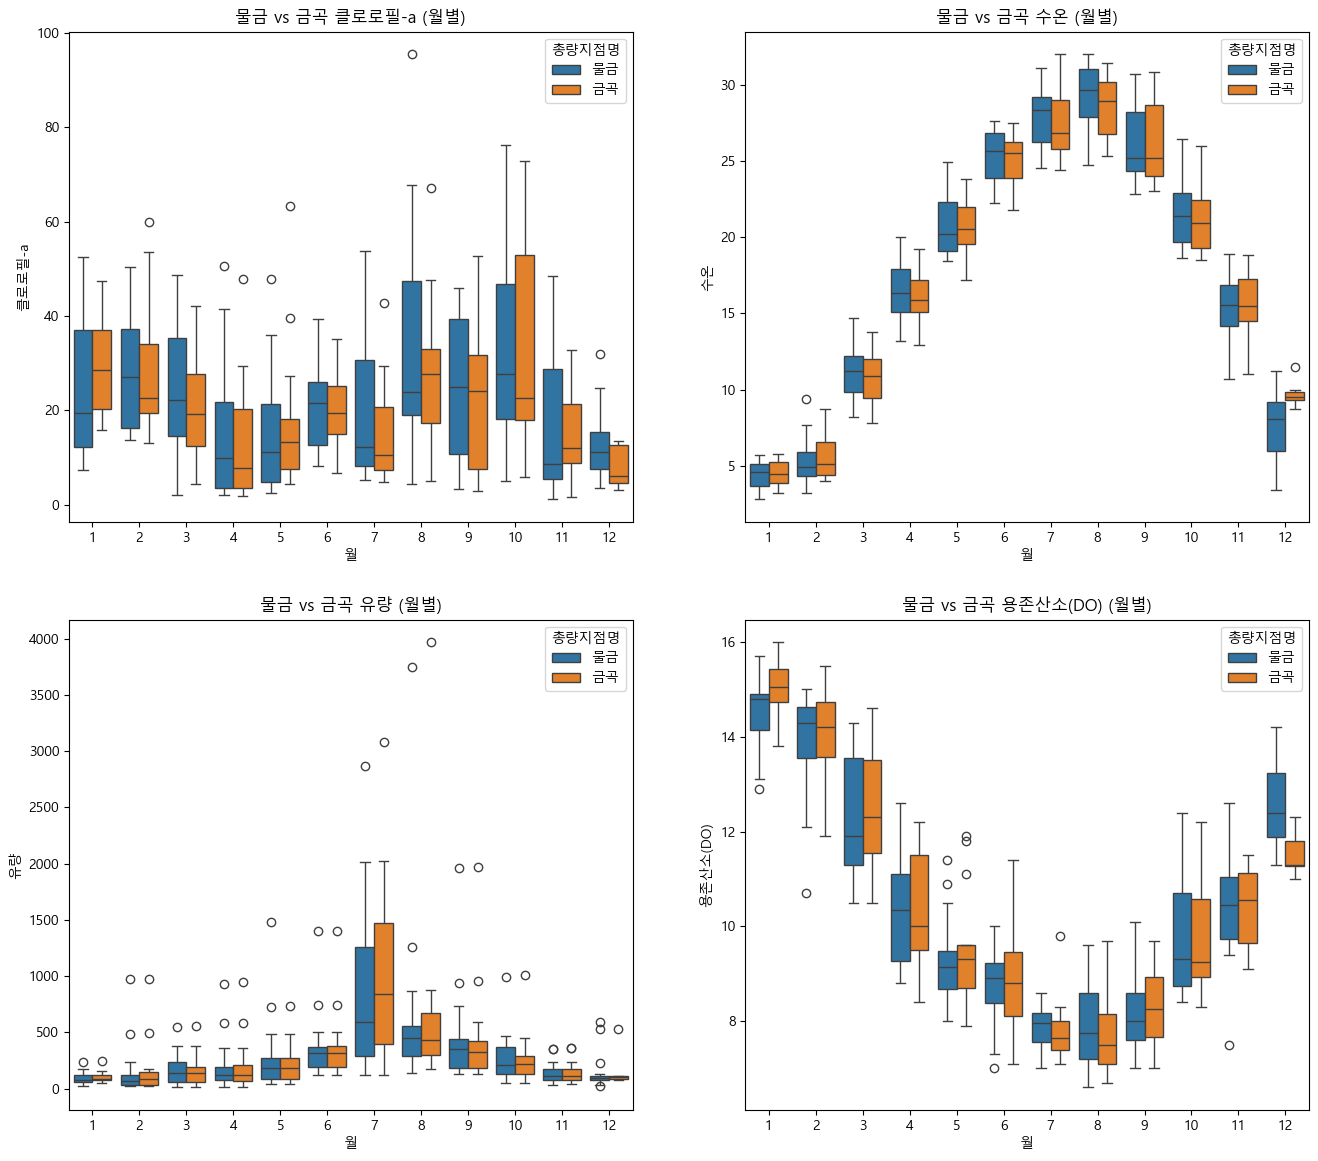

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

sb.boxplot(ax=axes[0,0], x='월', y='클로로필-a', hue='총량지점명', data=waterDF)
axes[0,0].set_title('물금 vs 금곡 클로로필-a (월별)')

sb.boxplot(ax=axes[0,1], x='월', y='수온', hue='총량지점명', data=waterDF)
axes[0,1].set_title('물금 vs 금곡 수온 (월별)')

sb.boxplot(ax=axes[1,0], x='월', y='유량', hue='총량지점명', data=waterDF)
axes[1,0].set_title('물금 vs 금곡 유량 (월별)')

sb.boxplot(ax=axes[1,1], x='월', y='용존산소(DO)', hue='총량지점명', data=waterDF)
axes[1,1].set_title('물금 vs 금곡 용존산소(DO) (월별)')

plt.show()

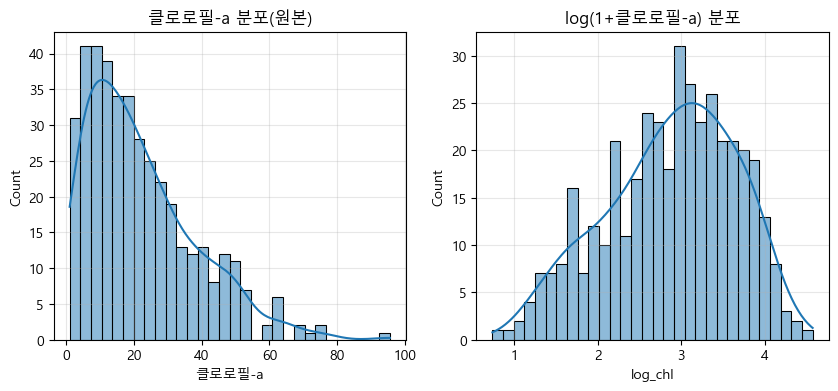

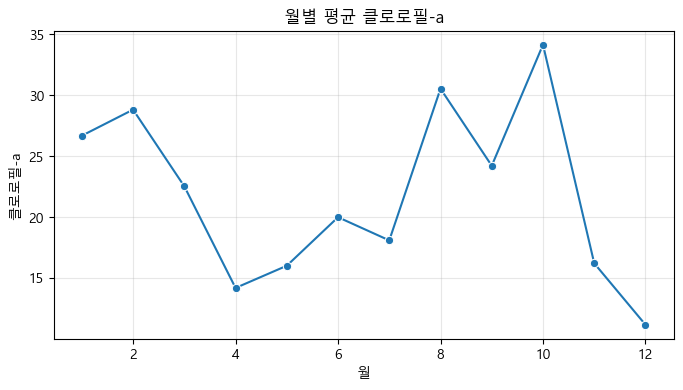

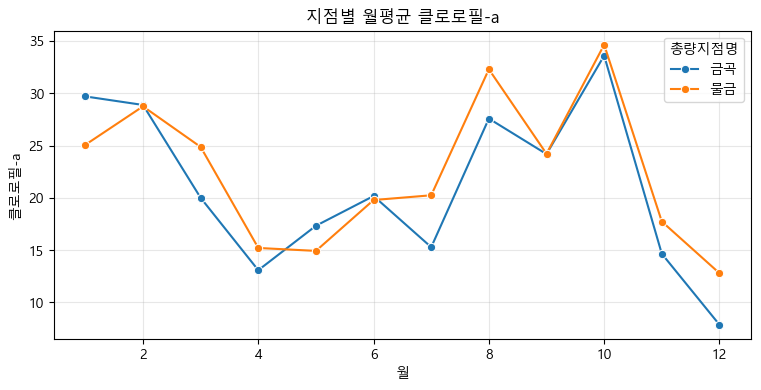

In [9]:
# 1) 클로로필-a 분포(원본/로그)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.histplot(waterDF['클로로필-a'], bins=30, kde=True)
plt.title('클로로필-a 분포(원본)'); plt.grid(alpha=0.3)

plt.subplot(1,2,2)
sb.histplot(waterDF['log_chl'], bins=30, kde=True)
plt.title('log(1+클로로필-a) 분포'); plt.grid(alpha=0.3)
plt.show()

# 2) 월별 평균(계절성)
monthly_mean = waterDF.groupby('월')['클로로필-a'].mean().reset_index()
plt.figure(figsize=(8,4))
sb.lineplot(data=monthly_mean, x='월', y='클로로필-a', marker='o')
plt.title('월별 평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()

# 3) 지점별 월평균(금곡/물금 비교)
site_month = waterDF.groupby(['총량지점명','월'])['클로로필-a'].mean().reset_index()
plt.figure(figsize=(9,4))
sb.lineplot(data=site_month, x='월', y='클로로필-a', hue='총량지점명', marker='o')
plt.title('지점별 월평균 클로로필-a'); plt.grid(alpha=0.3)
plt.show()

In [10]:
mulgeumDf.sort_index(inplace=True)
geumgogDf.sort_index(inplace=True)
mulgeumDf['유량_7일차']=mulgeumDf['유량'].shift(1)
geumgogDf['유량_7일차']=geumgogDf['유량'].shift(1)
geumgogDf['수온_7일차']=geumgogDf['수온'].shift(1)
mulgeumDf['수온_7일차']=mulgeumDf['수온'].shift(1)
def heat(df, ax, title_suffix=""):
    corr_matrix = df.corr(numeric_only=True)
    target_col = '클로로필-a' 
    chl_corr = corr_matrix[[target_col]].sort_values(by=target_col, ascending=False)
    sb.heatmap(chl_corr, annot=True, cmap='RdYlGn', fmt=".2f", cbar=True, ax=ax)
    ax.set_title(f'상관관계 히트맵 {title_suffix}')

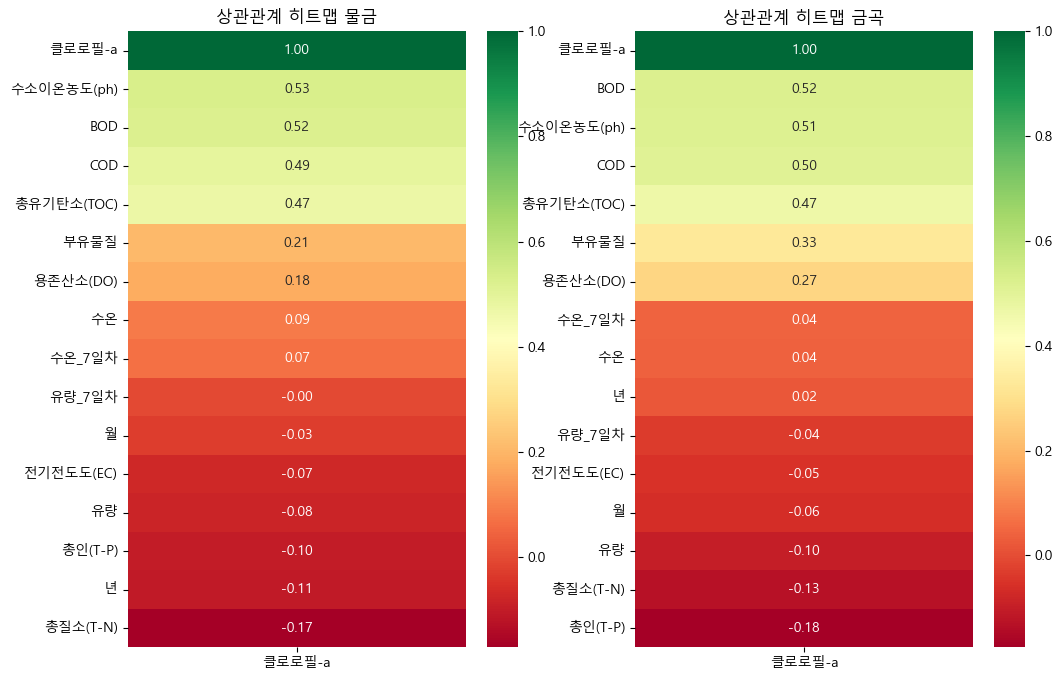

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
heat(mulgeumDf,axes[0],title_suffix="물금")
heat(geumgogDf,axes[1],title_suffix="금곡")
plt.show()